<a href="https://colab.research.google.com/github/benihime91/leaf-disease-classification-kaggle/blob/main/002_train_fold%3D0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# setup
!pip install pytorch-lightning --quiet
!pip install --upgrade albumentations --quiet
!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git

     |████████████████████████████████| 563kB 20.8MB/s 
     |████████████████████████████████| 829kB 51.7MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 276kB 54.2MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 952kB 10.4MB/s 
     |████████████████████████████████| 36.7MB 81kB/s 
Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 39 (delta 16), reused 25 (delta 8), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [2]:
! unzip -qq "/content/drive/MyDrive/cassava-leaf-disease-classification.zip" -d "/content/"

In [3]:
# set up paths to the data directories
image_dir = "/content/cassava-leaf-disease-classification/train_images"
csv_dir   = "/content/cassava-leaf-disease-classification/train.csv"
json_dir  = "/content/cassava-leaf-disease-classification/label_num_to_disease_map.json"

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir("/content/leaf-disease-classification-kaggle/")

%load_ext tensorboard
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# --------------------------------
# IMPORT LIBRARIES
# --------------------------------
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import logging
import argparse
import pandas as pd

from lightning import LitModel, LitDatatModule
from preprocess import Preprocessor

random.seed(42)
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)
pd.set_option("display.max_colwidth", None)

In [ ]:
# # Run this cell for 1st time run
# processor = Preprocessor(csv_dir, json_dir, image_dir, num_folds=5)
# processor._shuffle_and_create_folds()
# dataframe = processor.dataframe
# dataframe.to_csv("/content/fold_df.csv", index=False)
# dataframe.head()

In [6]:
# since we already have the fold dataset
fold_csv = "/content/leaf-disease-classification-kaggle/fold_df.csv"
processor = Preprocessor(csv_dir, json_dir, image_dir, num_folds=5)
# set the dataframe of Preprocessor to the the fold_csv
processor.dataframe = pd.read_csv(fold_csv)
processor.dataframe.head()

,image_id,label,filePath,kfold
0,2615227158.jpg,4,/content/cassava-leaf-disease-classification/train_images/2615227158.jpg,0
1,1277648239.jpg,3,/content/cassava-leaf-disease-classification/train_images/1277648239.jpg,0
2,2305895487.jpg,3,/content/cassava-leaf-disease-classification/train_images/2305895487.jpg,0
3,336299725.jpg,2,/content/cassava-leaf-disease-classification/train_images/336299725.jpg,0
4,1951270318.jpg,2,/content/cassava-leaf-disease-classification/train_images/1951270318.jpg,0


In [7]:
# -------------------------------
# Grab one FOLD
# -------------------------------
fold_num = 0
trainFold, valFold = processor.get_fold(fold_num)
testFold, valFold  = train_test_split(valFold, stratify=valFold.label, test_size=0.5) 

trainFold.reset_index(drop=True, inplace=True)
testFold.reset_index(drop=True, inplace=True)
valFold.reset_index(drop=True, inplace=True)

In [8]:
print("Length of train data:", len(trainFold))
print("Length of test data:", len(testFold))
print("Length of valid data:", len(valFold))

Length of train data: 17117
Length of test data: 2140
Length of valid data: 2140


In [9]:
weights = processor.weights
weights = torch.tensor(list(weights.values()))
weights

tensor([3.9369, 1.9550, 1.7935, 0.3252, 1.6606])

In [10]:
label_map = processor.label_map
label_map

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [11]:
def imshow(image, targets):
    """Imshow for Tensor."""
    grid = torchvision.utils.make_grid(images, normalize=True, nrow=4).permute(1, 2, 0).data.numpy()
    grid = np.array(grid * 255., dtype=np.uint)
    classes = targets.data.numpy()
    plt.figure(figsize=(15, 10))
    plt.axis("off")
    plt.imshow(grid)
    plt.title([label_map[i] for i in classes]);

In [12]:
image_dim = 224 # dimension of the image after resize

# Specify TRANSFORATIONS for TRAIN/VAL/TEST DATALOADERS
train_transformations = A.Compose([
    A.Rotate(p=0.5, limit=60),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(p=0.5),
    A.OneOf([A.RandomFog(), A.RandomRain(), A.RandomSnow()]),
    A.Resize(image_dim, image_dim, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(always_apply=True),

])

valid_transformations = A.Compose([
    A.Resize(image_dim, image_dim, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(always_apply=True)
])

test_transformations = valid_transformations

albu_transforms = {
    "train": train_transformations, 
    "valid": valid_transformations,
    "test" : test_transformations,
}

# Generate LIGHTNING-DATAMODULE
batch_size = 64
data_module = LitDatatModule(trainFold, valFold, testFold, batch_size, albu_transforms)

In [13]:
# -----------------------------------
# GENERATE TRAIN/VAL/TEST DATLOADERS
# ------------------------------------
data_module.setup()
train_dl = data_module.train_dataloader()
val_dl = data_module.val_dataloader()
test_dl = data_module.test_dataloader()

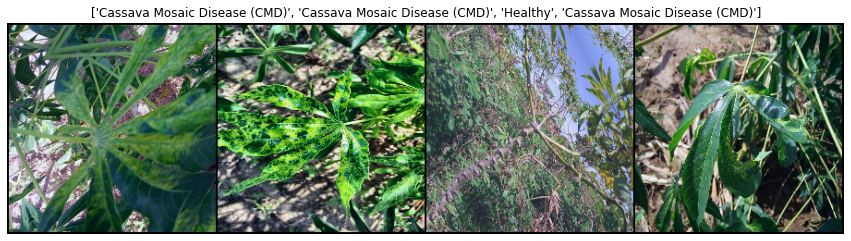

In [14]:
# TRAIN DATALOADER
batch = next(iter(train_dl))
images, targets = batch
example_input_array = images # needed to log graph to logger
images  = images[:4]
targets = targets[:4]
# view images from the DATALOADER
imshow(images, targets)

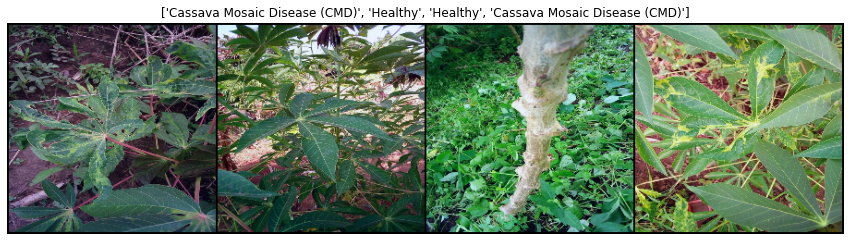

In [15]:
# VALID DATALOADER
batch = next(iter(val_dl))
images, targets = batch
images  = images[:4]
targets = targets[:4]
# view images from the DATALOADER
imshow(images, targets)

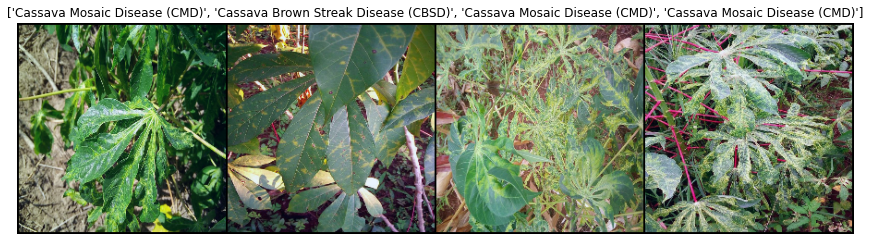

In [16]:
# TEST DATALOADER
batch = next(iter(test_dl))
images, targets = batch
images  = images[:4]
targets = targets[:4]
# view images from the DATALOADER
imshow(images, targets)

In [17]:
# -----------------------------------
# TRAINING ARGUMENTS
# ------------------------------------
num_epochs = 20
steps_per_epoch = len(train_dl)
total_steps = num_epochs * steps_per_epoch

learning_rate = 0.1
weight_decay = 0.01

output_dims = len(label_map)

logger = logging.getLogger("lightning")
logger.info(f"num_epochs: {num_epochs}")
logger.info(f"steps_per_epoch: {steps_per_epoch}")
logger.info(f"total_steps: {total_steps}")
logger.info(f"learning_rate: {learning_rate}")
logger.info(f"weight_decay: {weight_decay}")
logger.info(f"output_dims: {output_dims}")


parser = argparse.ArgumentParser()
parser.add_argument("--learning_rate", type=float, default=learning_rate, help="AdamW: learning rate")
parser.add_argument("--weight_decay", type=float, default=weight_decay, help="AdamW: weight_decay")
parser.add_argument("--total_steps", type=int, default=total_steps, help="total steps to train for")
parser.add_argument("--output_dims", type=int, default=output_dims, help="number of output classes")
args, _ = parser.parse_known_args()

PATH = "/content/checkpoints/"
LOGS = "/content/lightning_logs/"
os.makedirs(PATH, exist_ok=True)
os.makedirs(LOGS, exist_ok=True)

# Init trainer callbacks
model_checkpoint = pl.callbacks.ModelCheckpoint(filepath=PATH, monitor="val_loss", save_top_k=1)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")
logger = pl.loggers.TensorBoardLogger(save_dir=LOGS, log_graph=True, default_hp_metric=False)
callbacks = [lr_monitor]
# Init trainer
trainer = pl.Trainer(
    precision=16, 
    gpus=1, 
    logger=logger,
    checkpoint_callback=model_checkpoint, 
    callbacks=callbacks, 
    max_epochs=num_epochs, 
    max_steps=total_steps,
    gradient_clip_val=0.1,
    )

num_epochs: 20
steps_per_epoch: 268
total_steps: 5360
learning_rate: 0.1
weight_decay: 0.01
output_dims: 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [ ]:
# -------------------------------
# INSTANTIATE AND TRAIN MODEL
# --------------------------------
# Init DataModule
batch_size = 64
data_module = LitDatatModule(trainFold, valFold, testFold, batch_size, albu_transforms)
# Init model
model = LitModel(**vars(args), class_weights=weights)
model.example_input_array = example_input_array
# Pass the datamodule as arg to trainer.fit to override model hooks :)
trainer.fit(model, datamodule=data_module)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



  | Name    | Type             | Params | In sizes          | Out sizes
-----------------------------------------------------------------------------
0 | model   | Sequential       | 27 M   | [64, 3, 224, 224] | [64, 5]  
1 | loss_fn | CrossEntropyLoss | 0      | ?                 | ?        


In [ ]:
trainer.test(model, datamodule=data_module)

In [ ]:
%tensorboard --logdir "/content/lightning_logs/"

In [ ]:
torchmodel = model.model
# save torch model state dict
torch.save(torch.model.state_dict(), f"/content/modelWeights-Fold={fold_num}.pth")